In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

c:\Users\neved\sendhelp\plant-leaf-disease-classifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Setup and Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATA_ROOT = "./data"

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 20

Using device: cuda


## 3. Data Preparation

In [4]:
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

class_names = train_dataset.classes
print(f"Classes found: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Classes found: ['Apple_Black_Rot', 'Apple_Cedar_Rust', 'Apple_Healthy', 'Apple_Scab']
Training images: 2536
Validation images: 316
Test images: 319


## 4. Hybrid Model Definition (CNN + Transformer)

In [5]:
class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNTransformer, self).__init__()
        self.cnn_backbone = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0, global_pool=""
        )
        cnn_feature_dim = self.cnn_backbone.num_features

        embed_dim = 256
        self.projection = nn.Conv2d(cnn_feature_dim, embed_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=8, batch_first=True, dropout=0.2
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.projection(x)
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.transformer_encoder(x)
        cls_output = x[:, 0]
        cls_output = self.dropout(cls_output)
        output = self.fc(cls_output)
        return output

model = HybridCNNTransformer(num_classes=len(class_names)).to(device)

## 5. Training & Validation Loop

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
best_val_accuracy = 0.0

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    epoch_val_accuracy = val_corrects.double() / len(val_dataset)
    print(f"Epoch {epoch + 1}/{EPOCHS} | Val Acc: {epoch_val_accuracy:.4f}")

    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("   -> Validation accuracy improved, model saved!")

Epoch 1/20 | Val Acc: 0.9873
   -> Validation accuracy improved, model saved!
Epoch 2/20 | Val Acc: 0.9968
   -> Validation accuracy improved, model saved!
Epoch 3/20 | Val Acc: 1.0000
   -> Validation accuracy improved, model saved!


KeyboardInterrupt: 

## 6. Final Evaluation on the Test Set

--- Loading best model for final testing ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

 Apple_Black_Rot     1.0000    0.9365    0.9672        63
Apple_Cedar_Rust     1.0000    1.0000    1.0000        28
   Apple_Healthy     1.0000    0.9879    0.9939       165
      Apple_Scab     0.9130    1.0000    0.9545        63

        accuracy                         0.9812       319
       macro avg     0.9783    0.9811    0.9789       319
    weighted avg     0.9828    0.9812    0.9814       319



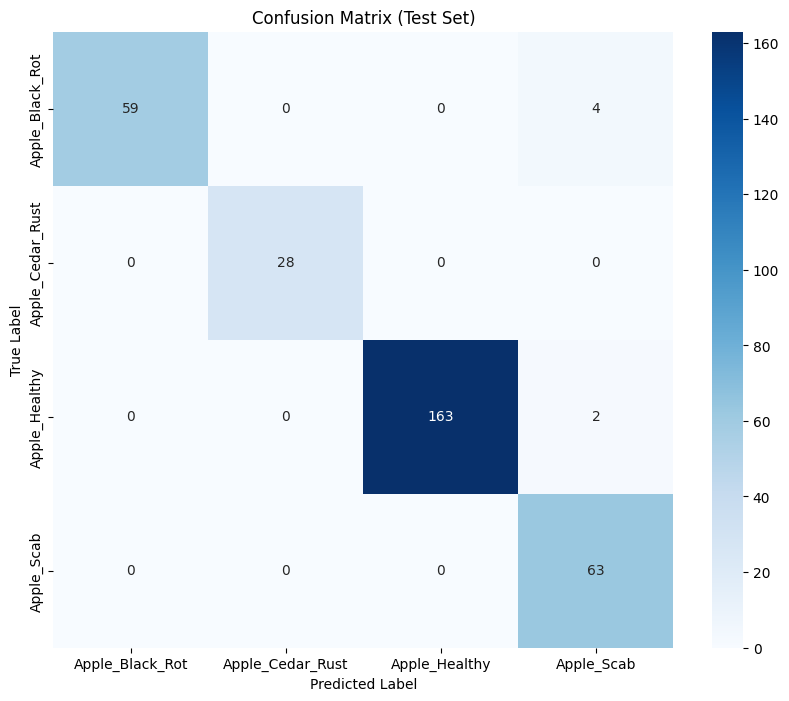

In [8]:
print("--- Loading best model for final testing ---")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()